### University of Washington: Machine Learning and Statistics 

# Lecture 4: Dimensionality Reduction
 
Andrew Connolly and Stephen Portillo

##### Resources for this notebook include:
- [Textbook](https://press.princeton.edu/books/hardcover/9780691198309/statistics-data-mining-and-machine-learning-in-astronomy) Chapter 8. 
- [astroML website](https://www.astroml.org/index.html)

This notebook is developed based on material from A. Connolly, Z. Ivezic, M. Juric, S. Portillo, G. Richards, B. Sipocz, J. VanderPlas, D. Hogg, and many others.

The notebook and assoociated material are available from [github](https://github.com/uw-astro/astr-598a-win22).

Make sure you are using the latest version of Jupyterlab (>3.0)
> pip install jupyterlab --upgrade

<a id='toc'></a>

## This notebook includes:


[The curse of dimensionality](#curse) 

[Principal Component Analysis](#PCA)
 
[Comparing PCA, NMF and ICA](#all3)

[Manifold Learning](#LLE) 

## The curse of dimensionality <a id='curse'></a>
[Go to top](#toc)

Fitting and overfitting get worse with ''curse of dimensionality'' Bellman 1961

Think about a hypersphere. Its volume is  given by


$$  V_D(r) = \frac{2r^D\pi^{D/2}}{D\  \Gamma(D/2)}$$

where $\Gamma(z)$ is the complete gamma function, $D$ is the dimension, and $r$ the radius of the sphere.


If you populated a hypercube of size $2r$ how much data would be enclosed by the hypersphere
- as $D$ increases the fractional volume enclosed by the hypersphere goes to 0! 

For example: the SDSS comprises a sample of 357 million sources. 
- each source has 448 measured attributes
- selecting just 30 (e.g., magnitude, size..) and normalizing the data range $-1$ to $1$

probability of having one of the 357 million sources reside within a unit hypersphere 1 in 1.4$\times 10^5$.

### Solution: dimensionality reduction!

## Increasing interest in dimensionality reduction
<img width="500" src="figures/PCA.png">

## Principal Component Analysis <a id='PCA'></a>
[Go to top](#toc)


![An example: a bivariate gaussian distribution](figures/pca-scatter.png)
 


Points are  correlated along a particular direction which doesn't align with the initial choice of axes. 
* we should rotate our axes to align with this correlation. 
* rotation preserves the relative ordering of data

Choose  rotation to maximize the ability to discriminate between the data points
*   first axis, or <u>principal component</u>, is direction of maximal variance
*   second principal component is orthogonal to the first component and maximizes the residual variance 

#### Singular value decomposition (SVD)
Common approach is eigenvalue decomposition of the covariance or correlation matrix,
or singular value decomposition (SVD) of the data matrix

$$U \Sigma V^T = \frac{1}{\sqrt{N - 1}} X$$

columns of $U$ are  _left-singular vectors_

columns of $V$ are the _right-singular vectors_

The columns of $U$ and $V$ form orthonormal bases ($U^TU = V^TV = I$)

Covariance matrix is

$$
  C_X = \left[\frac{1}{\sqrt{N - 1}}X\right]^T \left[\frac{1}{\sqrt{N - 1}}X\right]\nonumber\\
      = V \Sigma U^T U \Sigma V^T\nonumber\\
      = V \Sigma^2 V^T.
$$

right singular vectors $V$ are the principal components so principal from the SVD of $X$ dont need $C_X$.

#### Application of PCA

In the following example we have 100 data points in 3 dimensions, $X$, and $R$ as the projection matrix. To compute the PCA components (4 in our case) we use `PCA` from `scikit-learn`. 

- Center data by subtracting the mean of each dimension
-  For heterogeneous data (e.g., galaxy shape and flux) divide by variance (whitening). why?
- For spectra or images normalize each row so integrated flux of each object is one.

For our astronomy use case, we are using the SDSS spectroscopic dataset. 
The SDSS spectra come from galaxies at a range of redshifts,
and have sections of unreliable or missing data due to sky absorption, cosmic rays, bad detector pixels,
or other effects. AstroML provides a set of spectra which have been moved to rest frame, corrected
for masking using an iterative PCA reconstruction technique, and resampled to 1000 common wavelength bins. 

The spectra can be downloaded using `fetch_sdss_corrected_spectra()`. In the following example we plot
15 of these spectra:

In [1]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

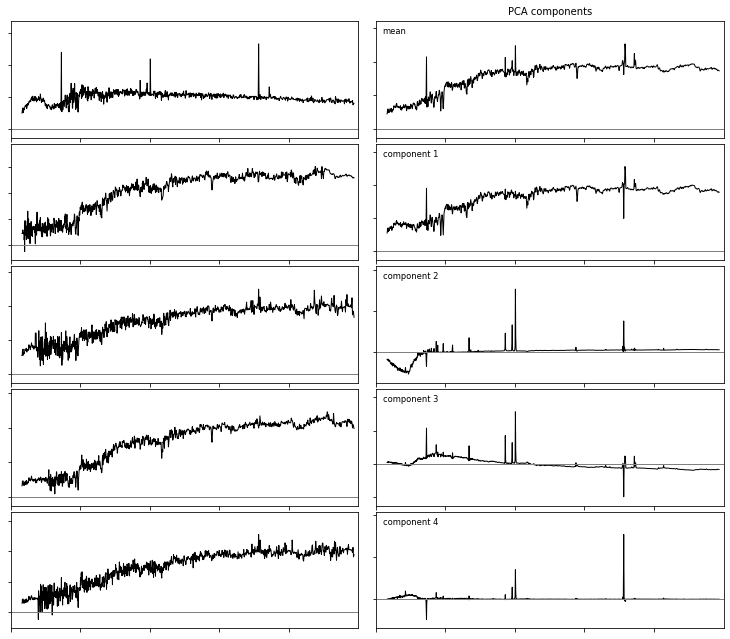

In [2]:
import numpy as np
from matplotlib import pyplot as plt

from sklearn.decomposition import PCA

from astroML.datasets import sdss_corrected_spectra
from astroML.decorators import pickle_results

#------------------------------------------------------------
# Download data
data = sdss_corrected_spectra.fetch_sdss_corrected_spectra()
spectra_raw = data['spectra']
spectra = sdss_corrected_spectra.reconstruct_spectra(data)
wavelengths = sdss_corrected_spectra.compute_wavelengths(data)

#----------------------------------------------------------------------
# Compute PCA: returns mean + PCA vectors
def compute_PCA(n_components=20):
    nrows = 500
    ind = np.random.randint(spectra.shape[0], size=nrows)
    spec_mean = spectra[ind].mean(0)

    # PCA
    pca = PCA(n_components - 1)
    pca.fit(spectra[ind])
    pca_comp = np.vstack([spec_mean,
                          pca.components_])
    evals = pca.explained_variance_ratio_

    return pca_comp, evals, ind

n_components = 25
decompositions, evals, index = compute_PCA(n_components)

#----------------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(11, 50))

fig.subplots_adjust(left=0.05, right=0.95, wspace=0.05,
                    bottom=0.1, top=0.95, hspace=0.05)

titles = 'PCA components'

for j in range(5):
    ax = fig.add_subplot(n_components, 2, 2*j+2)

    ax.yaxis.set_major_formatter(plt.NullFormatter())
    ax.xaxis.set_major_locator(plt.MultipleLocator(1000))
    if j < n_components - 1:
        ax.xaxis.set_major_formatter(plt.NullFormatter())
    else:
        ax.set_xlabel(r'wavelength ${\rm (\AA)}$')
    ax.plot(wavelengths, decompositions[j], '-k', lw=1)

    # plot zero line
    xlim = [3000, 7999]
    ax.plot(xlim, [0, 0], '-', c='gray', lw=1)
    ax.set_xlim(xlim)

    # adjust y limits
    ylim = plt.ylim()
    dy = 0.05 * (ylim[1] - ylim[0])    
    ax.set_ylim(ylim[0] - dy, ylim[1] + 4 * dy)


    ax2 = fig.add_subplot(n_components, 2, 2*j+1)
    ax2.yaxis.set_major_formatter(plt.NullFormatter())
    ax2.xaxis.set_major_locator(plt.MultipleLocator(1000))
    if j < n_components - 1:
        ax2.xaxis.set_major_formatter(plt.NullFormatter())
    else:
        ax2.set_xlabel(r'wavelength ${\rm (\AA)}$')
    ax2.plot(wavelengths, spectra[j], '-k', lw=1)
    
    # plot zero line
    ax2.plot(xlim, [0, 0], '-', c='gray', lw=1)
    ax2.set_xlim(xlim)

    if j == 0:
        ax.set_title(titles, fontsize='medium')

    if j == 0:
        label = 'mean'
    else:
        label = 'component %i' % j

    # adjust y limits
    ylim = plt.ylim()
    dy = 0.05 * (ylim[1] - ylim[0])    
    ax2.set_ylim(ylim[0] - dy, ylim[1] + 4 * dy)


    ax.text(0.02, 0.95, label, transform=ax.transAxes,
            ha='left', va='top', bbox=dict(ec='w', fc='w'),
            fontsize='small')

plt.show()

#### Interpreting the PCA

Reconstruction of spectrum, ${x}(k)$, from the
eigenvectors, ${e}_i(k)$ 

>$ \begin{equation}
  {x}_i(k) = {\mu}(k) + \sum_j^R \theta_{ij} {e}_j(k),
\end{equation}
$

Truncating this expansion (i.e., $r<R$)

>$\begin{equation}
{x}_i(k) = {\mu}(k) + \sum_i^{r<R} \theta_i {e}_i(k),
\end{equation}
$

- eigenvectors ordered by their associated eigenvalues 
- eigenvalues reflect variance  within each eigenvector (sum of the eigenvalues is total variance of the system).
- project a each spectrum onto these first few eigenspectra is a compression of the data 

This is the sense in which PCA gives for dimensionality reduction.

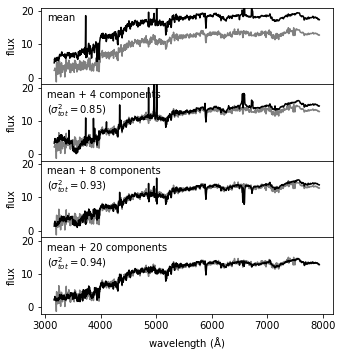

In [3]:
#  Because the spectra have been reconstructed from masked values, this
#  is not exactly correct in this case: we'll use the values computed
#  in the file compute_sdss_pca.py
evals = data['evals'] ** 2
evals_cs = evals.cumsum()
evals_cs /= evals_cs[-1]
evecs = data['evecs']
spec_mean = spectra.mean(0)

#------------------------------------------------------------
# Find the coefficients of a particular spectrum
spec = spectra[1]
coeff = np.dot(evecs, spec - spec_mean)

#------------------------------------------------------------
# Plot the sequence of reconstructions
fig = plt.figure(figsize=(5, 5))
fig.subplots_adjust(hspace=0, top=0.95, bottom=0.1, left=0.12, right=0.93)

for i, n in enumerate([0, 4, 8, 20]):
    ax = fig.add_subplot(411 + i)
    ax.plot(wavelengths, spec, '-', c='gray')
    ax.plot(wavelengths, spec_mean + np.dot(coeff[:n], evecs[:n]), '-k')

    if i < 3:
        ax.xaxis.set_major_formatter(plt.NullFormatter())

    ax.set_ylim(-2, 21)
    ax.set_ylabel('flux')

    if n == 0:
        text = "mean"
    elif n == 1:
        text = "mean + 1 component\n"
        text += r"$(\sigma^2_{tot} = %.2f)$" % evals_cs[n - 1]
    else:
        text = "mean + %i components\n" % n
        text += r"$(\sigma^2_{tot} = %.2f)$" % evals_cs[n - 1]

    ax.text(0.02, 0.93, text, ha='left', va='top', transform=ax.transAxes)

fig.axes[-1].set_xlabel(r'${\rm wavelength\ (\AA)}$')
plt.show()

### PCA with missing data

Observed spectrum, $x^o$ is the true spectrum, ${x}$ plus a wavelength-dependent weight, ${w}$.  

Weight is zero where data are missing and $1/{\sigma}^2$ for rest

Minimizing the quadratic deviation between  ${x}^o$ truncated reconstruction, $\sum_i \theta_i {e}_i$
and solving for $\theta_i$ gives

$$
	\sum_k \theta_i {w}(k) {e}_i(k) {e}_j(k) =
	\sum_k {w}(k) {x}^o(k) {e}_j(k),
$$

If $M_{ij} = \sum_k {w}(k) {e}_i(k) {e}_j(k)$ and $F_i = \sum_k {w}(k) {x}^o(k) {e}_i(k)$ then 

$$
	\theta_i = \sum_j M_{ij}^{-1} F_{j},
$$

- $F_j$ are  coefficients derived from  gappy data
- $M_{ij}^{-1}$ shows how correlated  eigenvectors are over the missing regions.

An estimate of the uncertainty on the
reconstruction coefficients is given by

$$
%Cov(\theta_i,\theta_j) = \frac{1}{N}M_{ij}^{-1}
{\rm Cov}(\theta_i,\theta_j) = M_{ij}^{-1}.
$$

Accuracy of this reconstruction will depend on the distribution of
the gaps within the data vector.

The principal component vectors defined for the SDSS spectra can be used to interpolate across or reconstruct
missing data. Examples of three masked spectral regions are shown comparing the reconstruction of the input 
spectrum (black line) using the mean and the first ten eigenspectra (blue line) The gray bands represent the 
masked region of the spectrum.

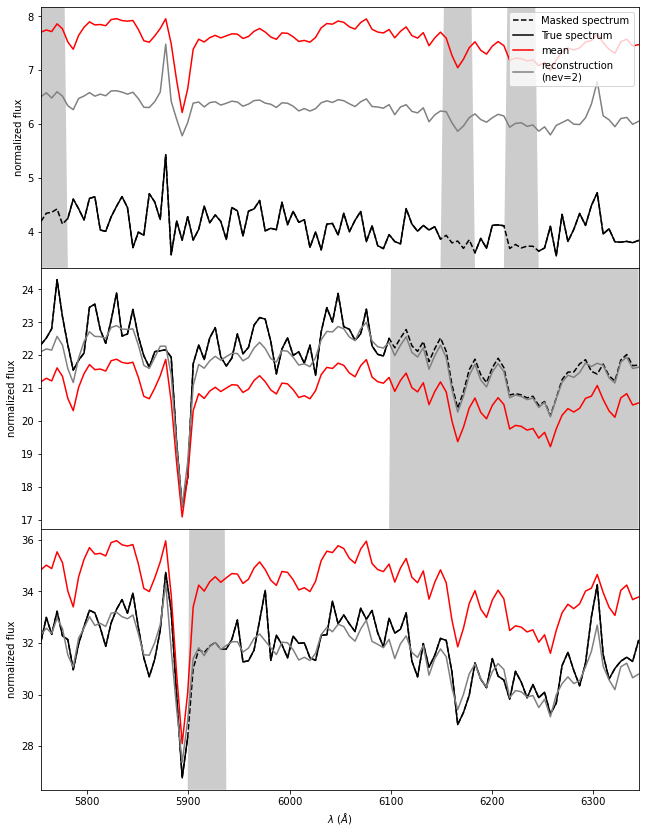

In [4]:
spectra = sdss_corrected_spectra.reconstruct_spectra(data)
wavelengths = sdss_corrected_spectra.compute_wavelengths(data)

evecs = data['evecs']
mu = data['mu']
norms = data['norms']
mask = data['mask']

#------------------------------------------------------------
# plot the results
i_plot = ((wavelengths > 5750) & (wavelengths < 6350))
wavelength = wavelengths[i_plot]

specnums = [20, 8, 9]
subplots = [311, 312, 313]

fig = plt.figure(figsize=(10, 12.5))
fig.subplots_adjust(left=0.09, bottom=0.08, hspace=0, right=0.92, top=0.95)

for subplot, i in zip(subplots, specnums):
    ax = fig.add_subplot(subplot)

    # compute eigen-coefficients
    spectra_i_centered = spectra[i] / norms[i] - mu
    coeffs = np.dot(spectra_i_centered, evecs.T)

    # plot the raw masked spectrum
    spectra_i = spectra[i]
    ax.plot(wavelength, spectra_i[i_plot], '--', color='k',
            label='Masked spectrum', lw=1.5)

    # blank out masked regions
    mask_i = mask[i]
    spectra_i[mask_i] = np.nan

    # plot the raw masked spectrum
    ax.plot(wavelength, spectra_i[i_plot], '-', color='k',
            label='True spectrum', lw=1.5)

    # plot two levels of reconstruction
    for nev in [0,2]:
        if nev == 0:
            label = 'mean'
            color='red'
        else:
            label = 'reconstruction\n(nev=%i)' % nev
            color='grey'
        spectra_i_recons = norms[i] * (mu + np.dot(coeffs[:nev], evecs[:nev]))
        ax.plot(wavelength, spectra_i_recons[i_plot], label=label, color=color)

    # plot shaded background in masked region
    ylim = ax.get_ylim()
    mask_shade = ylim[0] + mask[i][i_plot].astype(float) * ylim[1]
    plt.fill(np.concatenate([wavelength[:1], wavelength, wavelength[-1:]]),
             np.concatenate([[ylim[0]], mask_shade, [ylim[0]]]),
             lw=0, fc='k', alpha=0.2)

    ax.set_xlim(wavelength[0], wavelength[-1])
    ax.set_ylim(ylim)
    #ax.yaxis.set_major_formatter(ticker.NullFormatter())

    if subplot == 311:
        ax.legend(loc=1)

    ax.set_xlabel('$\lambda\ (\AA)$')
    ax.set_ylabel('normalized flux')

plt.show()

## Comparing PCA, NMF and ICA  <a id='all3'></a>
[Go to top](#toc)

### Nonnegative Matrix Factorization (NMF)

#### Non negative factorization

Eigenvectors are defined relative to a mean data vector. Principal components that can be positive or negative but for many physical systems we know data are a linear sum of positive components (e.g. galaxy spectrum is a linear sum of stellar components


Nonnegative matrix factorization (NMF) applies positivity constraint

Assumes that the data matrix $X$ is a product of two positive matrices, $X=Y*W$.

Solved iteratively for $Y$ and $W$ by minimizing the reconstruction error $||(X-WY)2||$

Nonnegative matrix factorization (NMF) applies positivity constraint.

In [5]:
from sklearn.decomposition import NMF

X = np.random.random((100, 3))  # 100 points in 3 dims, all positive
nmf = NMF(n_components=3)  # setting n_components is optional
nmf.fit(X)
proj = nmf.transform(X)  # project to 3 dimensions

comp = nmf.components_  # 3 x 10 array of components
err = nmf.reconstruction_err_  # how well 3 components captures data


### Independent component analysis

Independent component analysis (ICA) solves the ``cocktail party problem'', where there are multiple microphones situated through out a room containing
$N$ people. Each microphone picks up a linear combination of the $N$
voices. The goal of ICA is to use the concept of statistical
independence to isolate (or unmix) the individual signals. 

Each spectrum, $x_i(k)$, can be described by

>$x_1(k) = a_{11}s_1(k) + a_{12}s_2(k) + a_{13}s_3(k) + \cdots\\
x_2(k) = a_{21}s_1(k) + a_{22}s_2(k) + a_{23}s_3(k) + \cdots \\
x_3(k) = a_{31}s_1(k) + a_{32}s_2(k) + a_{33}s_3(k) + \cdots \\
$

where $s_i(k)$ are the individual  spectra and $a_{ij}$
the appropriate mixing amplitudes. 

In matrix form,
>$ X = A S$,

 Extracting these signal spectra is equivalent to estimating the appropriate weight matrix,
$W$, such that
>$ S = W X$.


Underlying ICA is the observation that the
input signals, $s_i(k)$, should be **statistically
independent** - the joint probability distribution, $f(x,y)$, can be
fully described by  $f(x^p,y^q)=f(x^p)f(y^q)$

 The rationale for ICA is that the
sum of any two independent random variables will always be more
Gaussian than either of the individual random variables (i.e., from the
central limit theorem). If we identify an unmixing matrix, $W$, that
maximizes the non-Gaussianity of the distributions, then we would be
identifying the input signals. 

In [6]:
from sklearn.decomposition import FastICA

X = np.random.normal(size=(100, 2))  # 100 pts in 2 dims
R = np.random.random((2, 5))  # mixing matrix
X = np.dot(X, R)  # X is now 2D data in 5D space
ica = FastICA(2)  # fit two components

sources = ica.fit_transform(X)
proj = ica.transform(X)  # 100 x 2 projection of data
comp = ica.components_  # the 2 x 5 matrix of indep. components

### Comparing PCA, NMF and ICA

A comparison of the decomposition of SDSS spectra using PCA (left panel), ICA (middle panel) and 
NMF (right panel). The rank of the component increases from top to bottom. For the ICA and PCA 
the first component is the mean spectrum (NMF does not require mean subtraction). All of these 
techniques isolate a common set of spectral features (identifying features associated with the 
continuum and line emission). The ordering of the spectral components is technique dependent.

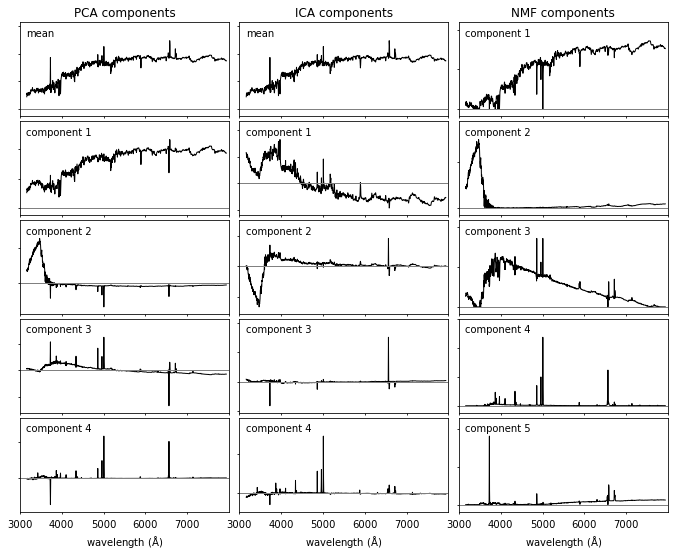

In [8]:
from sklearn.decomposition import NMF, FastICA, PCA

data = sdss_corrected_spectra.fetch_sdss_corrected_spectra()
spectra = sdss_corrected_spectra.reconstruct_spectra(data)
wavelengths = sdss_corrected_spectra.compute_wavelengths(data)

#----------------------------------------------------------------------
# Compute PCA, ICA, and NMF components
def compute_PCA_ICA_NMF(n_components=5):
    spec_mean = spectra.mean(0)

    # PCA: 
    pca = PCA(n_components - 1, random_state=0, svd_solver='randomized')
    pca.fit(spectra)
    pca_comp = np.vstack([spec_mean,
                          pca.components_])

    # ICA treats sequential observations as related.  Because of this, we need
    # to fit with the transpose of the spectra
    ica = FastICA(n_components - 1, random_state=0)
    ica.fit(spectra.T)
    ica_comp = np.vstack([spec_mean,
                          ica.transform(spectra.T).T])

    # NMF requires all elements of the input to be greater than zero
    spectra[spectra < 0] = 0
    nmf = NMF(n_components, random_state=0)
    nmf.fit(spectra)
    nmf_comp = nmf.components_

    return pca_comp, ica_comp, nmf_comp

n_components = 5
decompositions = compute_PCA_ICA_NMF(n_components)

#----------------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(10, 8))
fig.subplots_adjust(left=0.05, right=0.95, wspace=0.05,
                    bottom=0.1, top=0.95, hspace=0.05)

titles = ['PCA components', 'ICA components', 'NMF components']

for i, comp in enumerate(decompositions):
    for j in range(n_components):
        ax = fig.add_subplot(n_components, 3, 3 * j + 1 + i)

        ax.yaxis.set_major_formatter(plt.NullFormatter())
        ax.xaxis.set_major_locator(plt.MultipleLocator(1000))
        if j < n_components - 1:
            ax.xaxis.set_major_formatter(plt.NullFormatter())
        else:
            ax.xaxis.set_major_locator(
                plt.FixedLocator(list(range(3000, 7999, 1000))))
            ax.set_xlabel(r'wavelength ${\rm (\AA)}$')

        ax.plot(wavelengths, comp[j], '-k', lw=1)

        # plot zero line
        xlim = [3000, 8000]
        ax.plot(xlim, [0, 0], '-', c='gray', lw=1)

        if j == 0:
            ax.set_title(titles[i])

        if titles[i].startswith('PCA') or titles[i].startswith('ICA'):
            if j == 0:
                label = 'mean'
            else:
                label = 'component %i' % j
        else:
            label = 'component %i' % (j + 1)

        ax.text(0.03, 0.94, label, transform=ax.transAxes,
                ha='left', va='top')

        for l in ax.get_xticklines() + ax.get_yticklines():
            l.set_markersize(2)

        # adjust y limits
        ylim = plt.ylim()
        dy = 0.05 * (ylim[1] - ylim[0])

        ax.set_ylim(ylim[0] - dy, ylim[1] + 4 * dy)
        ax.set_xlim(xlim)


plt.show()

#### Summary of pracical properties of PCA, NMF, and ICA

The following table is a simple summary of the trade-offs along our axes of
accuracy, interpretability, simplicity, and speed in dimension
reduction methods, expressed in terms of high (H), medium
(M), and low (L) categories.

|Method | Accuracy | Interpretability | Simplicity | Speed |
|-------|----------|------------------|------------|-------|
|Principal component analysis | H | H | H |  H |
|Nonnegative matrix factorization | H | H | M | M|
|Independent component analysis | M | M | L | L |
|Locally linear embedding | H | M | H | H |

## Manifold Learning <a id='LLE'></a>

[Go to top](#toc)

Real-world data sets often have very nonlinear features (e.g. QSOs with broad lines) which are hard to describe compactly using linear eigenvectors. Manifold learning techniques search for a representation of these data within a lower dimensional space

<img src="http://www.astroml.org/_images/fig_S_manifold_PCA_1.png"></img>

#### Local Linear Embedding:

Step 1: define local geometry
- local neighborhoods determined from $k$ nearest neighbors.
- for each point calculate weights that reconstruct a point from its $k$ nearest
neighbors
>$
\begin{equation}
  \mathcal{E}_1(W) = \left|X - WX\right|^2
\end{equation}
$
- essentially this is finding the hyperplane that describes the local surface at each point within the data set. 

Step 2: embed within a lower dimensional space
- set all $W_{ij}=0$ except when point $j$ is one of the $k$ nearest neighbors of point $i$.  
- $W$ becomes very sparse for $k \ll N$.  
- minimize
>$\begin{equation}
  \mathcal{E}_2(Y) = \left|Y - W Y\right|^2,
\end{equation}
$

with $W$ fixed to find an $N$ by $d$ matrix ($d$ is the new dimensionality)

Step 1 requires a nearest-neighbor search.

Step 2 requires an
eigenvalue decomposition of the matrix $C_W \equiv (I-W)^T(I-W)$,


LLE has been applied to data as diverse as galaxy spectra, stellar spectra, and photometric light curves. 

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


 - finished LLE projection
 - removing 33 outliers for plot


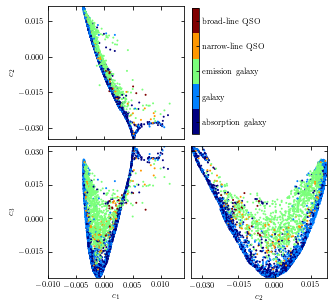

In [9]:
from astroML.plotting.tools import discretize_cmap
from astroML.decorators import pickle_results
from sklearn import manifold, neighbors

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=True)

#------------------------------------------------------------
# Set up color-map properties
clim = (1.5, 6.5)
cmap = discretize_cmap(plt.cm.jet, 5)
cdict = ['unknown', 'star', 'absorption galaxy',
         'galaxy', 'emission galaxy',
         'narrow-line QSO', 'broad-line QSO']
cticks = [2, 3, 4, 5, 6]
formatter = plt.FuncFormatter(lambda t, *args: cdict[int(np.round(t))])


#------------------------------------------------------------
# Fetch the data; PCA coefficients have been pre-computed
spec = sdss_corrected_spectra.reconstruct_spectra(data)
color = data['lineindex_cln']


#------------------------------------------------------------
# Compute the LLE projection; save the results
def compute_spec_LLE(n_neighbors=10, out_dim=3):
    # Compute the LLE projection
    LLE = manifold.LocallyLinearEmbedding(n_neighbors=n_neighbors, 
                                          n_components=out_dim,
                                          method='modified',
                                          eigen_solver='dense')
    Y_LLE = LLE.fit_transform(spec)
    print (" - finished LLE projection")

    # remove outliers for the plot
    BT = neighbors.BallTree(Y_LLE)
    dist, ind = BT.query(Y_LLE, n_neighbors)
    dist_to_n = dist[:, -1]
    dist_to_n -= dist_to_n.mean()
    std = np.std(dist_to_n)
    flag = (dist_to_n > 0.25 * std)
    print (" - removing %i outliers for plot" % flag.sum())

    return Y_LLE[~flag], color[~flag]

coeffs_LLE, c_LLE = compute_spec_LLE(10, 3)


#----------------------------------------------------------------------
# Plot the results:
for (c, coeffs, xlim) in zip([c_LLE],
                             [coeffs_LLE],
                             [(-0.01, 0.014)]):
    fig = plt.figure(figsize=(5, 5))
    fig.subplots_adjust(hspace=0.05, wspace=0.05)

    # axes for colorbar
    cax = plt.axes([0.525, 0.525, 0.02, 0.35])

    # Create scatter-plots
    scatter_kwargs = dict(s=4, lw=0, edgecolors='none', c=c, cmap=cmap)

    ax1 = plt.subplot(221)
    im1 = ax1.scatter(coeffs[:, 0], coeffs[:, 1], **scatter_kwargs)
    im1.set_clim(clim)
    ax1.set_ylabel('$c_2$')

    ax2 = plt.subplot(223)
    im2 = ax2.scatter(coeffs[:, 0], coeffs[:, 2], **scatter_kwargs)
    im2.set_clim(clim)
    ax2.set_xlabel('$c_1$')
    ax2.set_ylabel('$c_3$')

    ax3 = plt.subplot(224)
    im3 = ax3.scatter(coeffs[:, 1], coeffs[:, 2], **scatter_kwargs)
    im3.set_clim(clim)
    ax3.set_xlabel('$c_2$')

    fig.colorbar(im3, ax=ax3, cax=cax,
                 ticks=cticks,
                 format=formatter)

    ax1.xaxis.set_major_formatter(plt.NullFormatter())
    ax3.yaxis.set_major_formatter(plt.NullFormatter())

    ax1.set_xlim(xlim)
    ax2.set_xlim(xlim)

    for ax in (ax1, ax2, ax3):
        ax.xaxis.set_major_locator(plt.MaxNLocator(5))
        ax.yaxis.set_major_locator(plt.MaxNLocator(5))

plt.show()
 

### Exercise: for a set of spectra compare the coefficients from LLE and PCA coefficients by plotting the coefficicents  as a function of galaxy type



In [ ]:
# print the entries in the SDSS spectroscpic data set
for k in data.iterkeys():
    print (k)

#### spec_cln

- SPEC_UNKNOWN = 0
- SPEC_STAR    = 1
- SPEC_GALAXY  = 2
- SPEC_QSO     = 3
- SPEC_HIZ_QSO = 4 /* high redshift QSO, z>2.3, Ly-alpha finding code is triggered */ 
- SPEC_SKY     = 5 
- STAR_LATE    = 6 /* star dominated by molecular bands, Type M or later           */
- GAL_EM       = 7

 #### lineindex_cln

- 0 : unknown (SPEC_CLN = 0)
- 1 : star (SPEC_CLN = 1)
- 2 : absorption galaxy (H-alpha seen in absorption)
- 3 : normal galaxy (no significant H-alpha emission or absorption)
- 4 : emission line galaxies (below line-ratio curve)
- 5 : narrow-line QSO (above line-ratio curve)
- 6 : broad-line QSO (SPEC_CLN = 3)
- 7 : Sky (SPEC_CLN = 4)
- 8 : Hi-z QSO (SPEC_CLN = 5)
- 9 : Late-type star (SPEC_CLN = 6)
- 10 : Emission galaxy (SPEC_CLN = 7)